In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
! pip install wandb

     |████████████████████████████████| 1.4MB 3.4MB/s 
     |████████████████████████████████| 122kB 20.0MB/s 
     |████████████████████████████████| 102kB 8.6MB/s 
     |████████████████████████████████| 102kB 7.8MB/s 
     |████████████████████████████████| 163kB 16.0MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=85791fe26e6338669352e9bff8d769259e5047aee98303c35b7c045969d07362
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=414448bae60f272a63ca3f03f438266131c791377d72e560b6d3a687ce09199b
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=3a39

# Importing dependencies

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
# import wandb
# wandb.init(entity='kad99kev', project="mnist-gans", name="cgan", resume = 'True')


# Data Loading

## Download and normalize to range [-1, 1]

In [3]:
dataset_train = torchvision.datasets.MNIST('./train', train=True, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

Extracting ./train/MNIST/raw/train-images-idx3-ubyte.gz to ./train/MNIST/raw


Extracting ./train/MNIST/raw/train-labels-idx1-ubyte.gz to ./train/MNIST/raw


Extracting ./train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./train/MNIST/raw




Extracting ./train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataset_test = torchvision.datasets.MNIST('./test', train=False, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

Extracting ./test/MNIST/raw/train-images-idx3-ubyte.gz to ./test/MNIST/raw


Extracting ./test/MNIST/raw/train-labels-idx1-ubyte.gz to ./test/MNIST/raw




Extracting ./test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./test/MNIST/raw


Extracting ./test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./test/MNIST/raw
Processing...
Done!


## Concatenating train and test dataset

In [5]:
dataset = dataset_train + dataset_test
print(f'Length of complete dataset : {len(dataset)}')

Length of complete dataset : 70000


## Initializing constants

In [6]:
torch.cuda.is_available()

True

In [7]:
params = {}
params['epochs'] = 20
params['output_after_every_n_epochs'] = 1
params['image_size'] = 28
params['noise_size'] = 100
params['batch_size'] = 64
params['num_channels'] = 1
params['num_classes'] = 10
params['seed'] = 0
# wandb.config.update(params)

In [48]:
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(params['seed'])

## Convert into DataLoader

In [52]:
datasetloader = torch.utils.data.DataLoader(dataset_train, batch_size=params['batch_size'], shuffle=True)

In [50]:
dataiter = iter(datasetloader)

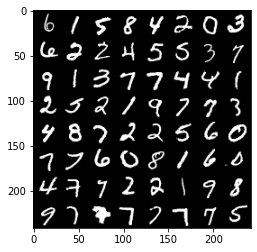

In [51]:
images, labels = dataiter.next()
show_grid(torchvision.utils.make_grid(images, normalize=True))

# Initialize Weights

In [ ]:
def initialize_weights(m): 
	if type(m) == nn.Linear:
		torch.nn.init.xavier_uniform_(m.weight)
		m.bias.data.fill_(0.01)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [ ]:
class Generator(nn.Module):
  '''
  The Generator Network
  '''

  def __init__(self, num_classes, noise_size, image_size, num_channels):
    super(Generator, self).__init__()

    self.num_classes = num_classes
    self.noise_size = noise_size
    self.image_size = image_size
    self.num_channels = num_channels
    self.label_emb = nn.Embedding(self.num_classes, self.num_classes)

    # First layer input -> (features + 10)
    self.linear_1 = nn.Sequential(
        nn.Linear(self.noise_size + self.num_classes, 128),
        nn.LeakyReLU(0.2, inplace=True)
    )
    # Out 128

    self.linear_2 = nn.Sequential(
        nn.Linear(128, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.BatchNorm1d(256, 0.8)
    )
    # Out 256

    self.linear_3 = nn.Sequential(
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.BatchNorm1d(512, 0.8)
    )
    # Out 512

    self.linear_4 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2, inplace=True),
        nn.BatchNorm1d(1024, 0.8)
    )
    # Out 1024

    self.output_layer = nn.Sequential(
        nn.Linear(1024, self.image_size ** 2),
        nn.Tanh()
    )
    # Out 784
    
    self.optimizer = optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.99))
    
  def forward(self, noise, labels):
    #Concat label embedding and image to produce input
    gen_input = torch.cat((self.label_emb(labels), noise), -1)
    x = self.linear_1(gen_input)
    x = self.linear_2(x)
    x = self.linear_3(x)
    x = self.linear_4(x)
    output_image = self.output_layer(x)
    output_image = output_image.view(output_image.size(0), self.num_channels, self.image_size, self.image_size)
    return output_image

In [ ]:
generator = Generator(params['num_classes'], params['noise_size'], params['image_size'], params['num_channels'])
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (label_emb): Embedding(10, 10)
  (linear_1): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_4): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
 

## Test output shape of Generator

torch.Size([64, 1, 28, 28])


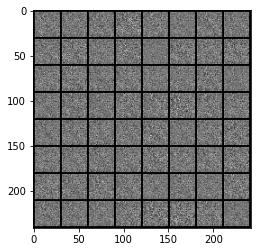

Generator(
  (label_emb): Embedding(10, 10)
  (linear_1): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_4): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
 

In [ ]:
with torch.no_grad():
  generator.eval()
  _, labels = dataiter.next()
  noise = torch.randn(size=(params['batch_size'], params['noise_size'])).cuda()
  output = generator(noise, labels.cuda()).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

# Discriminator

In [ ]:
class Discriminator(nn.Module):
  '''
  Discriminator neural network
  '''

  def __init__(self, num_classes):
    super(Discriminator, self).__init__()

    self.num_classes = num_classes
    self.label_emb = nn.Embedding(self.num_classes, self.num_classes)

    # First layer input -> (28 * 28 + 10)
    self.linear_1 = nn.Sequential(
        nn.Linear(self.num_classes + 28 ** 2, 512),
        nn.LeakyReLU(0.2, inplace=True),
    )
    # Out 128

    self.linear_2 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2, inplace=True)
    )
    # Out 256

    self.linear_3 = nn.Sequential(
        nn.Linear(1024, 1024),
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2, inplace=True)
    )
    # Out 512

    self.linear_4 = nn.Sequential(
        nn.Linear(1024, 512),
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2, inplace=True)
    )
    # Out 512

    self.output_layer = nn.Sequential(
        nn.Linear(512, 1),
        nn.Sigmoid()
    )
    # Out 1

    self.optimizer = optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.99))

  def forward(self, input_image, labels):
    #Concat label embedding and image to produce input
    dis_input = torch.cat((input_image.view(input_image.size(0), -1), self.label_emb(labels)), -1)
    x = self.linear_1(dis_input)
    x = self.linear_2(x)
    x = self.linear_3(x)
    x = self.linear_4(x)
    return self.output_layer(x)

In [ ]:
discriminator = Discriminator(params['num_classes'])
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (label_emb): Embedding(10, 10)
  (linear_1): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_4): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# Loss Function

In [ ]:
adversarial_loss = nn.BCELoss()

# Plotting output after each epoch

In [ ]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():
    fixed_noise = torch.randn(size=(params['num_classes'], params['noise_size'])).cuda()

    fake_labels = torch.tensor([i for i in range(10)]).cuda()
    
    generator.eval()
    test_images = generator(fixed_noise, fake_labels)
    generator.train()
  
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True, nrow=5)
    show_grid(grid)
  wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

# Training CGAN

Epoch: 1 / 20
Discriminator Total Loss: 0.325, Generator Total Loss: 2.130


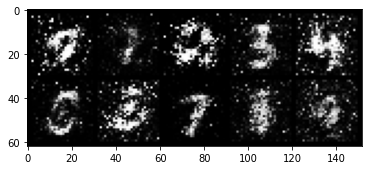

Epoch: 2 / 20
Discriminator Total Loss: 0.342, Generator Total Loss: 2.319


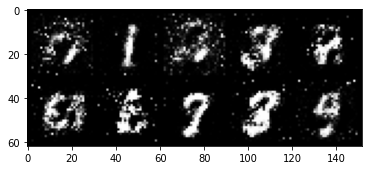

Epoch: 3 / 20
Discriminator Total Loss: 0.334, Generator Total Loss: 2.250


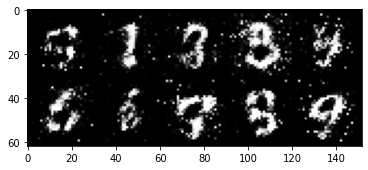

Epoch: 4 / 20
Discriminator Total Loss: 0.383, Generator Total Loss: 1.912


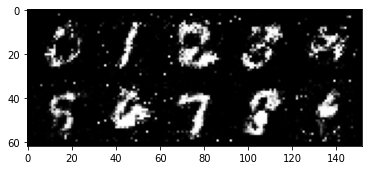

Epoch: 5 / 20
Discriminator Total Loss: 0.419, Generator Total Loss: 1.689


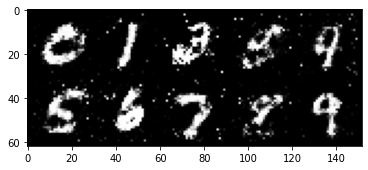

Epoch: 6 / 20
Discriminator Total Loss: 0.471, Generator Total Loss: 1.437


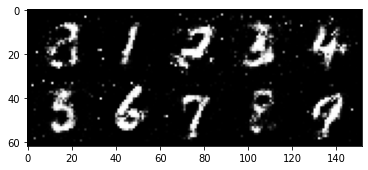

Epoch: 7 / 20
Discriminator Total Loss: 0.510, Generator Total Loss: 1.282


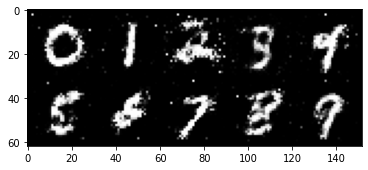

Epoch: 8 / 20
Discriminator Total Loss: 0.532, Generator Total Loss: 1.198


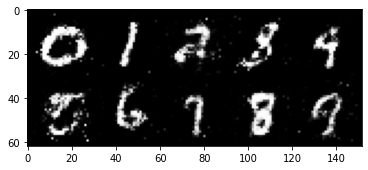

Epoch: 9 / 20
Discriminator Total Loss: 0.559, Generator Total Loss: 1.105


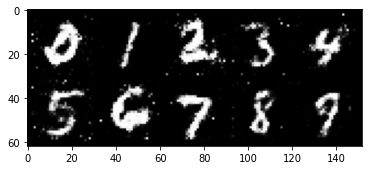

Epoch: 10 / 20
Discriminator Total Loss: 0.581, Generator Total Loss: 1.026


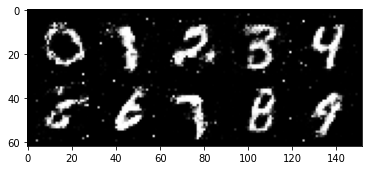

Epoch: 11 / 20
Discriminator Total Loss: 0.594, Generator Total Loss: 0.986


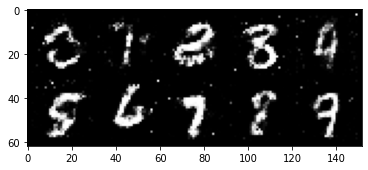

Epoch: 12 / 20
Discriminator Total Loss: 0.604, Generator Total Loss: 0.957


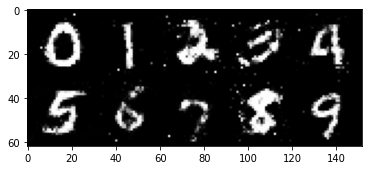

Epoch: 13 / 20
Discriminator Total Loss: 0.612, Generator Total Loss: 0.932


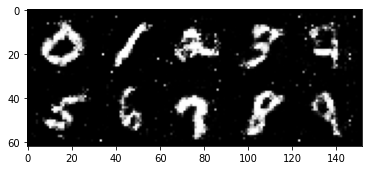

Epoch: 14 / 20
Discriminator Total Loss: 0.617, Generator Total Loss: 0.918


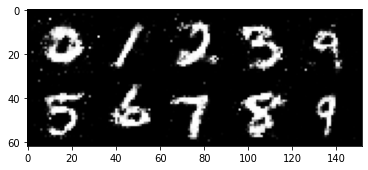

Epoch: 15 / 20
Discriminator Total Loss: 0.620, Generator Total Loss: 0.909


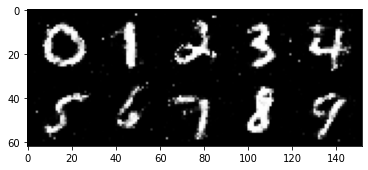

Epoch: 16 / 20
Discriminator Total Loss: 0.625, Generator Total Loss: 0.895


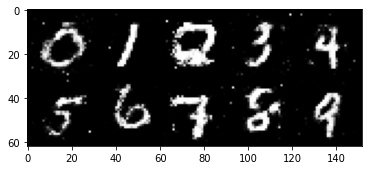

Epoch: 17 / 20
Discriminator Total Loss: 0.626, Generator Total Loss: 0.886


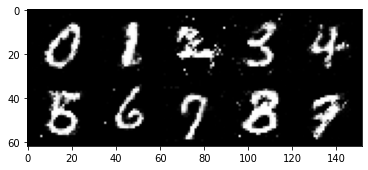

Epoch: 18 / 20
Discriminator Total Loss: 0.631, Generator Total Loss: 0.875


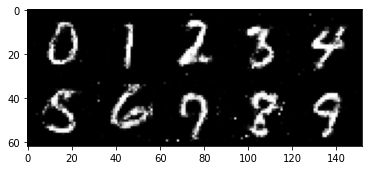

Epoch: 19 / 20
Discriminator Total Loss: 0.632, Generator Total Loss: 0.869


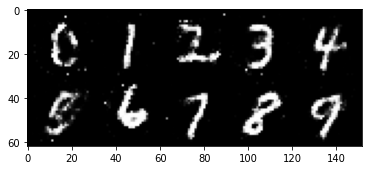

Epoch: 20 / 20
Discriminator Total Loss: 0.636, Generator Total Loss: 0.858


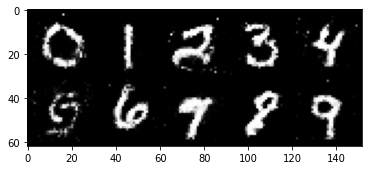

True

In [ ]:
# Set tdqm for epoch progress
pbar = tqdm()

wandb.watch(generator)
wandb.watch(discriminator)

for epoch in range(params['epochs']):
  print(f'Epoch: {epoch + 1} / {params["epochs"]}')
  pbar.reset(total=len(datasetloader))

  # Setting up losses
  discriminator_total_losses = []
  generator_total_losses = []

  for real_images, real_labels in datasetloader:
    
    # Current batch size
    current_batch_size = real_images.size()[0]

    # Convert to cuda
    real_images = real_images.cuda()
    real_labels = real_labels.cuda()

    # For real vs fake
    real_validity = torch.ones(current_batch_size).cuda()
    fake_validity = torch.zeros(current_batch_size).cuda()


    # Training generator
    generator.zero_grad()

    ## Generate fake images
    input_noise = torch.randn(size=(current_batch_size, params['noise_size'])).cuda()
    fake_labels = torch.randint(params['num_classes'], size=(current_batch_size, )).cuda()
    
    fake_images = generator(input_noise, fake_labels)


    discriminator_fake_validity = discriminator(fake_images, fake_labels)
    
    generator_loss = adversarial_loss(discriminator_fake_validity.squeeze(), real_validity)
    generator_loss.backward()
    generator.optimizer.step()
    generator_total_losses.append(generator_loss)
    
    
    #Train discriminator
    discriminator.zero_grad()

    ## Loss for real images
    discriminator_real_validity = discriminator(real_images, real_labels)
    discriminator_real_loss = adversarial_loss(discriminator_real_validity.squeeze(), real_validity)

    ## Loss for fake images
    discriminator_fake_validity = discriminator(fake_images.detach(), fake_labels)
    discriminator_fake_loss = adversarial_loss(discriminator_fake_validity.squeeze(), fake_validity)

    # Total discriminator loss
    discriminator_loss = (discriminator_real_loss + discriminator_fake_loss) / 2
    discriminator_loss.backward()
    discriminator.optimizer.step()
    discriminator_total_losses.append(discriminator_loss)
    
    # Update tqdm
    pbar.update()

  print('Discriminator Total Loss: {:.3f}, Generator Total Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_total_losses)),
          torch.mean(torch.FloatTensor(generator_total_losses))
        ))

  wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_total_losses)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_total_losses))}, step=epoch+1)
  if (epoch + 1) % params['output_after_every_n_epochs'] == 0:
    plot_output(epoch+1)

pbar.refresh()

In [ ]:
generator.eval()
discriminator.eval()  
torch.save(generator.state_dict(), '/content/drive/My Drive/Incubator/saved_models/MNIST_CGANS/generator.pt')
torch.save(discriminator.state_dict(), '/content/drive/My Drive/Incubator/saved_models/MNIST_CGANS/discriminator.pt')
generator.train()
discriminator.train()  


Discriminator(
  (label_emb): Embedding(10, 10)
  (linear_1): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_4): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# Output

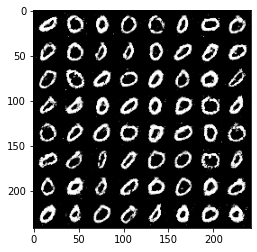

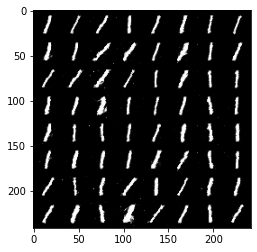

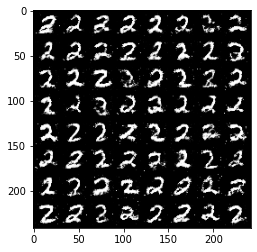

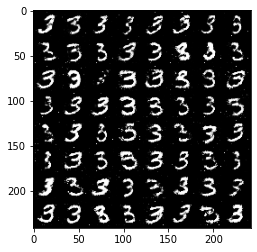

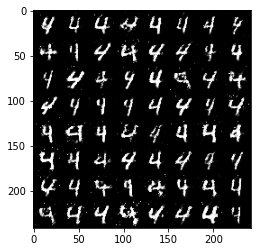

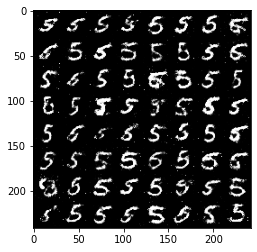

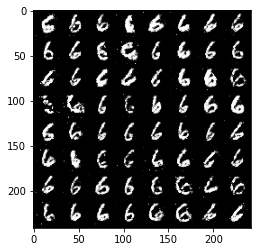

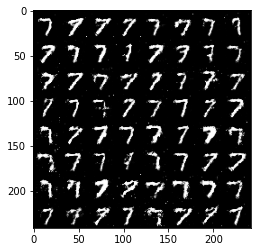

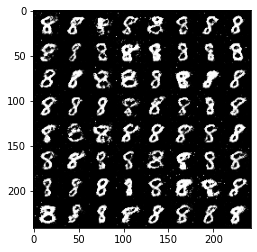

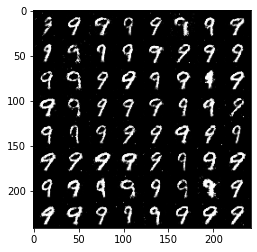

In [ ]:
images = []
with torch.no_grad():
  generator.eval()

  for num in range(10):
    input_noise = torch.randn(size=(batch_size, input_size)).cuda()
    input_labels = torch.tensor([num for _ in range(batch_size)]).cuda()

    output = generator(input_noise, input_labels)

    grid = torchvision.utils.make_grid(output.cpu(), normalize=True)
    show_grid(grid)
    images.append(transforms.ToPILImage()(grid))

In [ ]:
# Save gif of output
images[0].save('digitmnist-cgan.gif', save_all=True, append_images=images[1:])

In [ ]:
import wandb
api = wandb.Api()

# run is specified by <entity>/<project>/<run id>
run = api.run("elita04/gans/elvymjuw")

# save the metrics for the run to a csv file
metrics_dataframe = run.history()
metrics_dataframe.to_csv("metrics.csv")

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
